# Climate spirals using global temperature anomaly using CMIP6

* read in data
* caculate global anormaly
* capture monthly average snapshot of each year
* save as a GIF image

This example uses Coupled Model Intercomparison Project (CMIP6) collections. For more information, please visit [data catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f5194_5909_8003_9216) and [terms of use]( https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html).

---

- Authors: NCI Virtual Research Environment Team
- Keywords: Climate spiral, CMIP
- Create Date: 2020-Jul
    
---

Lineage:

This animiation is motivated by Ed Hawker's climate spirals:
https://www.climate-lab-book.ac.uk/2016/spiralling-global-temperatures/

In [1]:
import xarray as xr

In [2]:
path_CMIP6 = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/\
Amon/tas/gn/v20191115/*.nc'
tas = xr.open_mfdataset(path_CMIP6,combine='by_coords').tas
tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
dask.array<open_dataset-55d4bdbee9d8a9597fc8ae71f2848828tas, shape=(1980, 145, 192), dtype=float32, chunksize=(1980, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T03:52:23Z altered by CMOR: Treated scalar dime...

In [3]:
tas = tas-273.15
tas.sel(lat=-45,lon=116,time='1850-01-01',method='nearest').values

array(12.672241, dtype=float32)

In [4]:
file_area = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/\
r1i1p1f1/fx/areacella/gn/v20191115/areacella_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc')
area = file_area.areacella
#Calculate the area weighted mean.
tas_area = tas*area
tas_wmean = tas_area.sum(['lat','lon']) / (area.sum())
tas_anom = tas_wmean - tas_wmean.mean()
tas_anom.plot()  

To adjust the data to contain no negative temperature values, we need to first calculate the minimum temperature value, then minues this minimum value.

Let’s also generate 12 evenly spaced values from 0 to 2*pi and use the first 12 as the theta values:

(0.0, 6.0)

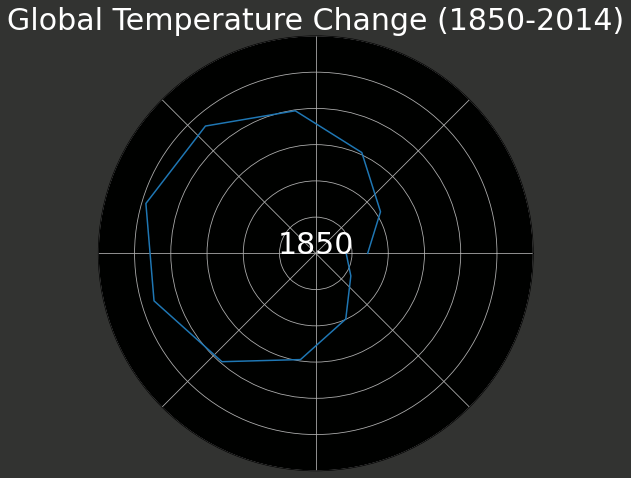

In [5]:
import numpy as np
from matplotlib import pyplot as plt
year1 = 1850
%matplotlib inline
hc_1850 = tas_anom.values[1:13]
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')
r = hc_1850 + 3 
theta = np.linspace(0, 2*np.pi, 12)
ax1.plot(theta, r)
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])
fig.set_facecolor("#323331")
ax1.set_facecolor('#000100')
ax1.set_title("Global Temperature Change (1850-2014)", color='white', fontdict={'fontsize': 30})
ax1.text(0,0,str(year1), color='white', size=30, ha='center')
ax1.set_ylim(0, 6)

Text(1.5707963267948966, 6.0, '3.0 C')

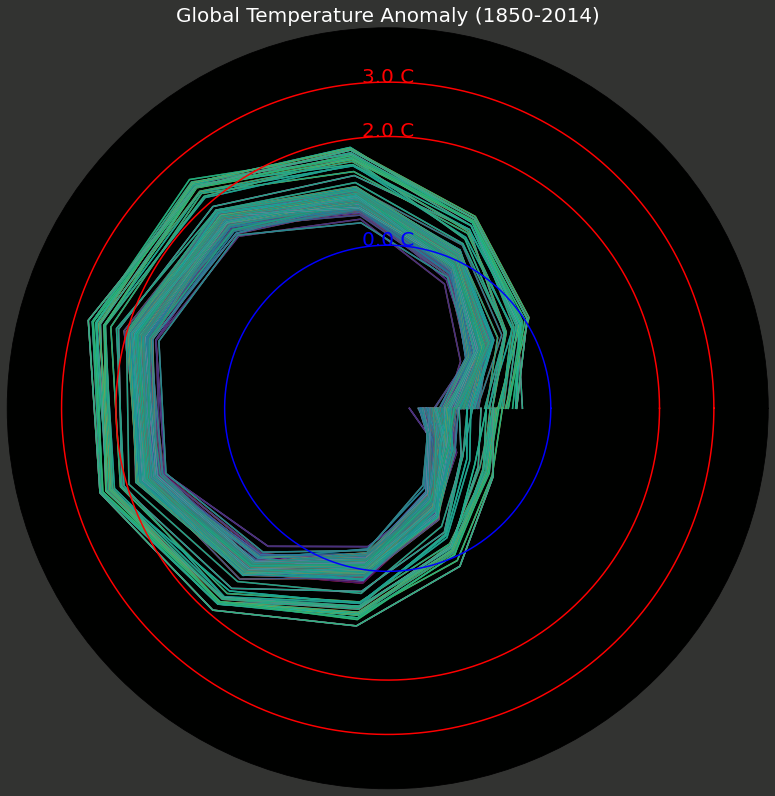

In [6]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(111, projection='polar')

ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])
fig.set_facecolor("#323331")
ax1.set_ylim(0, 7)

theta = np.linspace(0, 2*np.pi, 12)

ax1.set_title("Global Temperature Anomaly (1850-2014)", color='white', fontdict={'fontsize': 20})
ax1.set_facecolor('#000100')

y = tas_anom.values

for i in range(len(y)//12):
    year = i+1850
    if i < len(y)//12-1:
        r = y[i*12+1:i*12+13] + 3
    elif i == len(y//12)-1:
        print(i)
        r = y[-12:]  + 3        
    ax1.plot(theta, r)
    #ax1.text(0,0, str(year), color='white', size=30, ha='center')
    ax1.plot(theta, r, c=plt.cm.viridis(i)) # Index is a counter variable
    ax1.grid(False)
    
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
blue_line_one_radii = [3.0]*1000
red_line_one_radii = [5.0]*1000
red_line_two_radii = [6.0]*1000

ax1.plot(full_circle_thetas, blue_line_one_radii, c='blue')
ax1.plot(full_circle_thetas, red_line_one_radii, c='red')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')

ax1.text(np.pi/2, 3.0, "0.0 C", color="blue", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, 5.0, "2.0 C", color="red", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, 6.0, "3.0 C", color="red", ha='center', fontdict={'fontsize': 20})

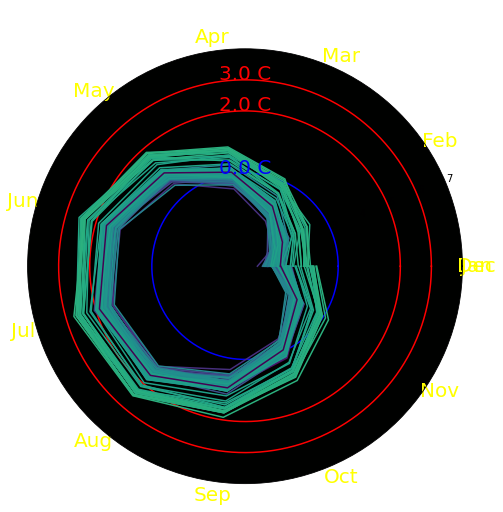

In [7]:
# To be able to write out the animation as a GIF file

import sys
from matplotlib.animation import FuncAnimation
# Create the base plot
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')

def update(i):
    # Specify how we want the plot to change in each frame.
    # We need to unravel the for loop we had earlier.
    if i < len(y)//12-1:
        r = y[i*12:i*12+12] + 3
    elif i == len(y//12)-1:
        r = y[-12:] + 3
    ax1.plot(theta, r, c=plt.cm.viridis(i))
    ax1.grid(False)
    return ax1


# setting a title for the plot 
ax1.set_title("Global Temperature Anomaly (1850-2014)", color='white', fontdict={'fontsize': 20})
plt.axis('on') 
plt.xticks(theta, 
           ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=20,color="yellow")
ax1.set_facecolor('#000100')
ax1.set_ylim(0, 7)
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
blue_line_one_radii = [3.0]*1000
red_line_one_radii = [5.0]*1000
red_line_two_radii = [6.0]*1000

ax1.plot(full_circle_thetas, blue_line_one_radii, c='blue')
ax1.plot(full_circle_thetas, red_line_one_radii, c='red')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')

ax1.text(np.pi/2, 3.0, "0.0 C", color="blue", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, 5.0, "2.0 C", color="red", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, 6.0, "3.0 C", color="red", ha='center', fontdict={'fontsize': 20})
anim = FuncAnimation(fig, update, frames=i, interval=50)
    
anim.save('climate_spiral.gif', dpi=120, writer='imagemagick', savefig_kwargs={'facecolor': '#323331'})